# 05_Model_Evaluation_and_Error_Analysis

##### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
import joblib

pd.set_option("display.max_columns", 100)


##### Load Data & Model

In [2]:
df = pd.read_parquet(
    "data/cleaned/yellow_taxi_features_hourly_zone_2025.parquet"
)

model = joblib.load(
    "outputs/models/lightgbm_hourly_zone_demand.pkl"
)

df = df.sort_values("pickup_hour_ts")


##### Recreate Train/Test Split (Same as Notebook 4)

In [3]:
split_date = df["pickup_hour_ts"].quantile(0.8)

train = df[df["pickup_hour_ts"] <= split_date]
test  = df[df["pickup_hour_ts"] > split_date]

FEATURES = [
    c for c in df.columns
    if c not in ["demand", "pickup_hour_ts"]
]

X_test = test[FEATURES]
y_test = test["demand"]


##### Predictions & Errors

In [4]:
test = test.copy()

test["prediction"] = model.predict(X_test)
test["error"] = test["prediction"] - test["demand"]
test["abs_error"] = np.abs(test["error"])


### PART 1 — Overall Performance

##### Overall MAE

In [5]:
overall_mae = mean_absolute_error(
    test["demand"], test["prediction"]
)

overall_mae


5.342687673252222

### PART 2 — Performance by Zone

##### MAE per Zone

In [6]:
zone_mae = (
    test
    .groupby("PULocationID")["abs_error"]
    .mean()
    .sort_values(ascending=False)
)

zone_mae.head(10)


PULocationID
132    32.187703
138    31.924050
142    26.154756
186    25.978290
237    23.404163
161    23.207063
236    21.887147
230    20.096299
79     18.318298
162    18.293911
Name: abs_error, dtype: float64

In [7]:
zone_mae.tail(10)


PULocationID
111    0.413471
251    0.412724
46     0.397685
187    0.394784
8      0.385411
207    0.376190
118    0.368306
30     0.355698
27     0.354168
253    0.302221
Name: abs_error, dtype: float64

##### Zone Error Distribution

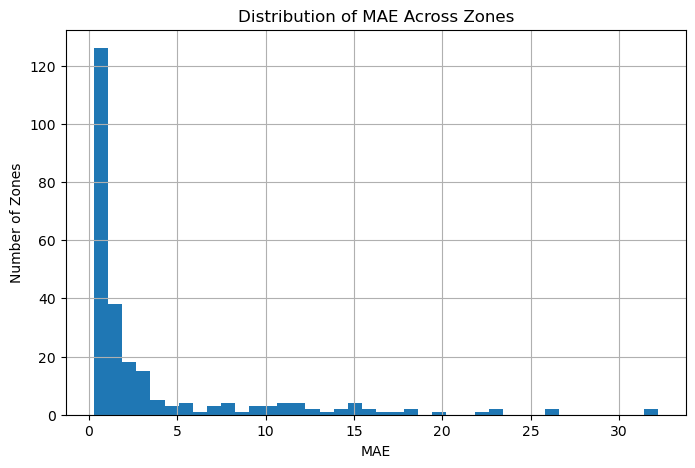

In [8]:
plt.figure(figsize=(8,5))
zone_mae.hist(bins=40)
plt.title("Distribution of MAE Across Zones")
plt.xlabel("MAE")
plt.ylabel("Number of Zones")
plt.show()


### PART 3 — Performance by Time

##### Error by Hour

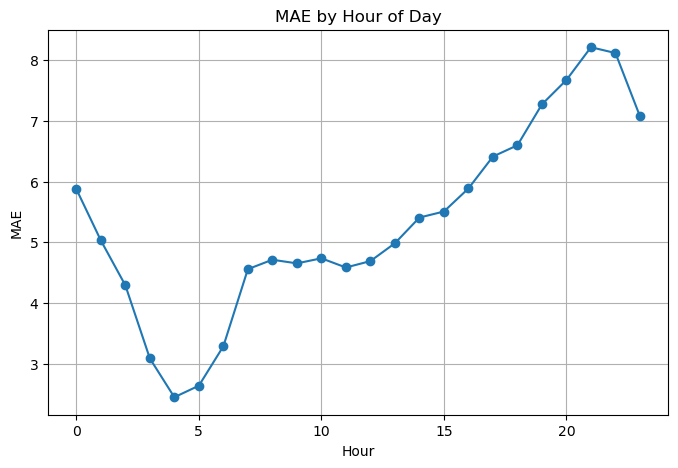

In [9]:
hourly_error = (
    test
    .groupby("hour")["abs_error"]
    .mean()
)

plt.figure(figsize=(8,5))
hourly_error.plot(marker="o")
plt.title("MAE by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


##### Weekday vs Weekend

In [10]:
weekend_error = (
    test
    .groupby("is_weekend")["abs_error"]
    .mean()
)

weekend_error


is_weekend
0    5.230920
1    5.585511
Name: abs_error, dtype: float64

### PART 4 — Residual Analysis

##### Actual vs Predicted

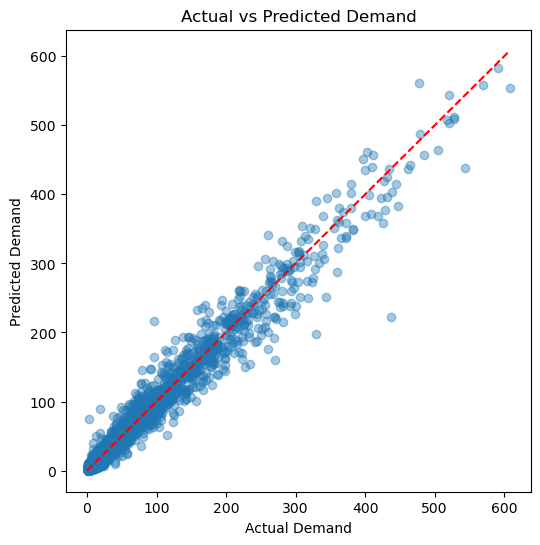

In [11]:
sample = test.sample(5000, random_state=42)

plt.figure(figsize=(6,6))
plt.scatter(sample["demand"], sample["prediction"], alpha=0.4)
plt.plot([0, max(sample["demand"])], [0, max(sample["demand"])], "--r")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.show()


##### Residuals Over Time

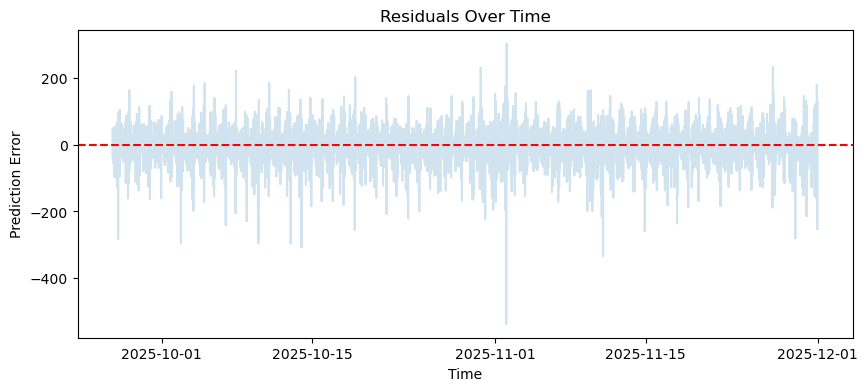

In [12]:
plt.figure(figsize=(10,4))
plt.plot(test["pickup_hour_ts"], test["error"], alpha=0.2)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Prediction Error")
plt.show()


### PART 5 — Key Insights

#### Key Insights

- The model performs consistently across most zones, with higher errors in a small number of high-demand or irregular zones.
- Prediction errors increase during rush hours, indicating higher volatility in demand.
- Weekend demand is slightly harder to predict than weekday demand.
- Residual analysis shows no strong temporal drift, suggesting stable model behavior.
